In [5]:
import numpy as np
from mnist.loader import MNIST
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
data = MNIST('input')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import wget
import random as rn

In [6]:
devices = tf.config.get_visible_devices()
devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

<center><span style="color:blue"><b>-----------------------------</b
    ></span></center>
<center><span style="color:blue"><b>1 ) Data Preparation</b
    ></span></center>
    <center><span style="color:blue"><b>-----------------------------</b
    ></span></center>

<span style="color:Grey"><b>a) URLs</b
    ></span>

In [7]:
train_im_url='https://csci7850-emnist.nyc3.digitaloceanspaces.com/emnist-balanced-train-images-idx3-ubyte'
train_labels_url='https://csci7850-emnist.nyc3.digitaloceanspaces.com/emnist-balanced-train-labels-idx1-ubyte'
test_im_url="https://csci7850-emnist.nyc3.digitaloceanspaces.com/emnist-balanced-test-images-idx3-ubyte"
test_labels_url="https://csci7850-emnist.nyc3.digitaloceanspaces.com/emnist-balanced-test-labels-idx1-ubyte"

<span style="color:Grey"><b>b) Download</b
    ></span>

In [8]:
train_images = wget.download(train_im_url)
train_labels_url = wget.download(train_labels_url)
test_im_url = wget.download(test_im_url)
test_labels_url = wget.download(test_labels_url)

<span style="color:Grey"><b>c) Data Normalization</b
    ></span>

In [9]:
x_train, y_train = data.load(train_images,
                                   train_labels_url)
x_test, y_test = data.load(test_im_url,
                                 test_labels_url)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
def Normalize(x, MinMax = False, Std = False):
    pixel_size = int(math.sqrt(x.shape[1]))
    if MinMax == True:
        scaler = MinMaxScaler()
        x_train_minmax = scaler.fit_transform(x)
        return x_train_minmax.reshape(x_train_minmax.shape[0], #112800
                          pixel_size, #28
                          pixel_size, #28
                          1)
    elif Std == True:
        std = StandardScaler()
        x_train_std = std.fit_transform(x)
        return x_train_std.reshape(x_train_std.shape[0], 
                          pixel_size, #28
                          pixel_size, #28
                          1)
x_train_std = Normalize(x_train, MinMax = False, Std =True)
x_test_std = Normalize(x_test, MinMax = False, Std =True)
x_train_minmax = Normalize(x_train, MinMax = True, Std =False)
x_test_minmax = Normalize(x_test, MinMax = True, Std =False)
y_train=y_train.reshape(y_train.shape[0],1)
y_test=y_test.reshape(y_test.shape[0],1)

In [10]:
print('x_train_minmax' + '=' + str(x_train_minmax.shape))
print('y_train' + '=' + str(y_train.shape))
print('x_test_minmax' + '=' + str(x_test_minmax.shape))
print('y_test' + '=' + str(y_test.shape))

x_train_minmax=(112800, 28, 28, 1)
y_train=(112800, 1)
x_test_minmax=(18800, 28, 28, 1)
y_test=(18800, 1)


<center><span style="color:blue"><b>-----------------------------</b
    ></span></center>
<center><span style="color:blue"><b>2) View Data</b
    ></span></center>
<center><span style="color:blue"><b>-----------------------------</b
    ></span></center>

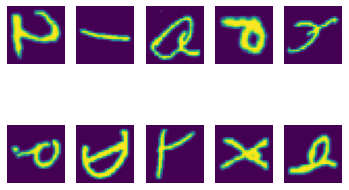

In [11]:
num=0
for im in rn.sample(range(0, 112800), 10):
    num = num+1
    plt.subplot(2,5,num)
    plt.axis('off')
    plt.imshow(x_train[im:im+1].reshape(28,28))

<center><span style="color:blue"><b>-----------------------------</b
    ></span></center>
<center><span style="color:blue"><b>3)Model Creation</b
    ></span></center>
<center><span style="color:blue"><b>-----------------------------</b
    ></span></center>

<span style="color:Blue"><b>a) Resnet50v2</b
    ></span>

In [12]:
x = keras.layers.Input(shape=x_train_minmax.shape[1:])
y=x
y = keras.layers.Conv2DTranspose(1,(2,2),2)(y)
#y = keras.layers.Conv2DTranspose(3,(4,4),4)(y)
resnet = keras.applications.ResNet50V2(weights=None, classes=len(np.unique(y_train))
                                       , input_shape=y.shape[1:])
y = resnet(y)
Resnet_model = keras.Model(x,y)
Resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [13]:
Resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 56, 56, 1)        5         
 nspose)                                                         
                                                                 
 resnet50v2 (Functional)     (None, 47)                23654831  
                                                                 
Total params: 23,654,836
Trainable params: 23,609,396
Non-trainable params: 45,440
_________________________________________________________________


In [14]:
# history = model.fit(x_train_minmax,y_train,
#                         validation_split=0.2,
#                         epochs=6,
#                         verbose=1)

<h><span style="color:Blue"><b>b) Custom Model</b
    ></span></h>

In [15]:
x = keras.layers.Input(shape=x_train_minmax.shape[1:])
y=x
y=keras.layers.Conv2D(filters = 512,kernel_size = 5
                      , padding='valid', 
                      activation ='relu',
                                 name = 'Conv_1')(y)

y=keras.layers.MaxPooling2D(pool_size=2, strides=2, name='pool_1')(y)
y = keras.layers.BatchNormalization()(y)
#------------------------------------------------------------------------------#
y=keras.layers.Conv2D(filters = 512,kernel_size = 5, 
                       padding='valid', 
                       activation ='relu',
                                  name = 'Conv_2')(y)
y = keras.layers.BatchNormalization()(y)
#y=keras.layers.MaxPooling2D(pool_size=2, strides=2, name='pool_2')(y)

#------------------------------------------------------------------------------#
y=keras.layers.Conv2D(filters = 1024,kernel_size = 3, 
                       padding='valid', 
                       activation ='relu',
                                  name = 'Conv_3')(y)
#------------------------------------------------------------------------------#
y = keras.layers.GlobalAveragePooling2D(name='avg_pool')(y)
y=keras.layers.Dropout(0.1)(y)
y = keras.layers.Dense(188, activation='relu')(y)
y = keras.layers.Dense(188, activation='relu')(y)
y = keras.layers.Dense(188, activation='relu')(y)

y = keras.layers.Dense(len(np.unique(y_train)), activation='softmax', name='predictions')(y)
model = keras.Model(x,y, name='EMNIST')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [16]:
model.summary()

Model: "EMNIST"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Conv_1 (Conv2D)             (None, 24, 24, 512)       13312     
                                                                 
 pool_1 (MaxPooling2D)       (None, 12, 12, 512)       0         
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 512)      2048      
 ormalization)                                                   
                                                                 
 Conv_2 (Conv2D)             (None, 8, 8, 512)         6554112   
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                            

In [17]:
# history = model.fit(x_train_minmax,y_train,
#                         validation_split=0.2,
#                         epochs=6,
#                         verbose=1)

<span style="color:blue"><b>c)MobileNetV2</b
    ></span>

In [18]:
x = keras.layers.Input(shape=x_train_minmax.shape[1:])
y=x
#y = keras.layers.Conv2DTranspose(1,(2,2),2)(y)
y = keras.layers.Conv2DTranspose(3,(4,4),4)(y)
mobile = keras.applications.MobileNetV2(weights=None, classes=len(np.unique(y_train))
                                       , input_shape=y.shape[1:])
y = mobile(y)
model = keras.Model(x,y,name="MobileNet")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])  

In [19]:
model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 112, 112, 3)      51        
 ranspose)                                                       
                                                                 
 mobilenetv2_1.00_112 (Funct  (None, 47)               2318191   
 ional)                                                          
                                                                 
Total params: 2,318,242
Trainable params: 2,284,130
Non-trainable params: 34,112
_________________________________________________________________


In [20]:
# history = model.fit(x_train_minmax,y_train,
#                         validation_split=0.2,
#                         epochs=6,
#                         verbose=1)

<center><span style="color:blue"><b>--------------------------------------</b
    ></span></center>
<center><span style="color:blue"><b>4)Data Augmentation on test set</b
    ></span></center>
    <center><span style="color:blue">--------------------------------------</span></center>

In [21]:
data_generator = ImageDataGenerator(
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    rotation_range=20,
                    zoom_range=0.2,
                    #horizontal_flip=True)
    )

dg_trainer = data_generator.flow(x_test_minmax, y_test, batch_size=32)

<center><span style="color:blue"><b>--------------------------------------</b
    ></span></center>
<center><span style="color:blue"><b>5)Downloading Pre-trained Models</b
    ></span></center>
    <center><span style="color:blue">--------------------------------------</span></center>

<span style="color:brown"><b>a)Custom Model</b
    ></span>

<span style="color:black"><b>#Architecture</b
    ></span>

In [115]:
mymodel_arch_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/mymodel_wo_DA_arch.json'
mymodel_arch = wget.download(mymodel_arch_URL)
with open(mymodel_arch,"r") as json_file:
    Custom_model = keras.models.model_from_json(json_file.read())
Custom_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

<span style="color:black"><b>#Weights without Data Augmentation</b
    ></span>

In [116]:
mymodel_wo_DA_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/mymodel_wo_DA_weights.h5'
mymodel_wo_DA_weights = wget.download(mymodel_wo_DA_URL)
Custom_model.load_weights(mymodel_wo_DA_weights)

In [117]:
score_model_wo_DA_rtest=Custom_model.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 35s 59ms/step - loss: 0.3219 - sparse_categorical_accuracy: 0.8853


In [118]:
score_model_wo_DA=Custom_model.evaluate(dg_trainer, verbose=1)

588/588 [==============================] - 34s 58ms/step - loss: 0.7622 - sparse_categorical_accuracy: 0.7520


<span style="color:black"><b>#Weights with Augmentation</b
    ></span>

In [119]:
mymodel_DA_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/mymodel_with_DA_weights.h5'
mymodel_DA_weights = wget.download(mymodel_DA_URL)
Custom_model.load_weights(mymodel_DA_weights)

In [120]:
score_model_DA_rtest=Custom_model.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 35s 59ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.8863


In [121]:
score_model_DA=Custom_model.evaluate(dg_trainer, verbose=1)

588/588 [==============================] - 35s 59ms/step - loss: 0.3621 - sparse_categorical_accuracy: 0.8702


<span style="color:brown"><b>b)Resnet50v2</b
    ></span>

<span style="color:black"><b>#Architecture</b
    ></span>

In [30]:
res_arch_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/resnet_wo_DA_arch.json'
resnet_arch = wget.download(res_arch_URL)
with open(resnet_arch,"r") as json_file:
    Resnet_model = keras.models.model_from_json(json_file.read())
Resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

<span style="color:black"><b>#Weights without Data Augmentation</b
    ></span>

In [31]:
res_wo_DA_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/resnet_wo_DA_weights.h5'
resnet_wo_DA_weights = wget.download(res_wo_DA_URL)
Resnet_model.load_weights(resnet_wo_DA_weights)

In [34]:
score_res_wo_DA_rtest=Resnet_model.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 53s 89ms/step - loss: 0.3360 - sparse_categorical_accuracy: 0.8841


In [32]:
#score_res_wo_DA=Resnet_model.evaluate(x_test_minmax, y_test, verbose=1)
score_res_wo_DA=Resnet_model.evaluate(dg_trainer, verbose=1)


588/588 [==============================] - 52s 88ms/step - loss: 0.7684 - sparse_categorical_accuracy: 0.7587


<span style="color:black"><b>#Weights with Augmentation</b
    ></span>

In [35]:
res_DA_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/resnet_with_DA_weights.h5'
resnet_DA_weights = wget.download(res_DA_URL)
Resnet_model.load_weights(resnet_DA_weights)

In [37]:
score_res_DA_rtest=Resnet_model.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 58s 98ms/step - loss: 0.3162 - sparse_categorical_accuracy: 0.8856


In [36]:
score_res_DA=Resnet_model.evaluate(dg_trainer, verbose=1)

588/588 [==============================] - 52s 89ms/step - loss: 0.3243 - sparse_categorical_accuracy: 0.8801


<span style="color:brown"><b>c)MobileNetV2</b
    ></span>

<span style="color:black"><b>#Architecture with weights (Without Data Augmentation</b
    ></span>

In [38]:
Mobilenet_arch_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/mobilenet_scratch_wo_daug.h5'
Mobilenet_arch = wget.download(Mobilenet_arch_URL)
Mobilenet = keras.models.load_model(Mobilenet_arch)
Mobilenet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [39]:
score_mobilenet_wo_DA_rtest=Mobilenet.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 39s 66ms/step - loss: 0.4667 - sparse_categorical_accuracy: 0.8484


In [40]:
score_mobilenet_wo_DA=Mobilenet.evaluate(dg_trainer, verbose=1)

588/588 [==============================] - 40s 68ms/step - loss: 1.2077 - sparse_categorical_accuracy: 0.6720


<span style="color:black"><b>#Architecture with weights (With Data Augmentation)</b
    ></span>

In [41]:
Mobilenet_arch_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/mobilenet_scratch_with_daug.h5'
Mobilenet_arch = wget.download(Mobilenet_arch_URL)
Mobilenet = keras.models.load_model(Mobilenet_arch)
Mobilenet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000025),
loss=keras.losses.SparseCategoricalCrossentropy(),
metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [42]:
score_mobilenet_DA_rtest=Mobilenet.evaluate(x_test_minmax, y_test, verbose=1)

588/588 [==============================] - 40s 68ms/step - loss: 0.3445 - sparse_categorical_accuracy: 0.8751


In [43]:
score_mobilenet_DA=Mobilenet.evaluate(dg_trainer, verbose=1)

588/588 [==============================] - 39s 65ms/step - loss: 0.3947 - sparse_categorical_accuracy: 0.8594


<center><span style="color:blue"><b>--------------------------------------</b
    ></span></center>
<center><span style="color:blue"><b>6)Comparison among the models</b
    ></span></center>
    <center><span style="color:blue">--------------------------------------</span></center>

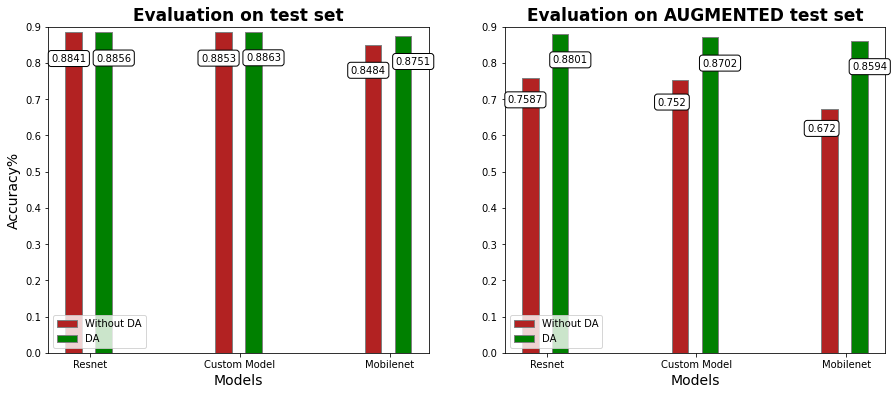

In [180]:
# set width of bar
from matplotlib.pyplot import figure
def addlabels(x,y,x1,y1):
    for i in range(len(x)):
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        plt.text(i-.15, y[i]/1.1, y[i], bbox = props)
    for i in range(len(x1)):
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        plt.text(i+.15, y1[i]/1.1, y1[i], bbox = props)
barWidth = 0.11
#fig, ax = plt.subplots(figsize =(8, 5))
figure(num=None, figsize=(15, 6))
plt.subplot(1,2,1)
# set height of bar
Wo_DA = [float('{0:.4f}'.format(score_res_wo_DA_rtest[1])), 
         float('{0:.4f}'.format(score_model_wo_DA_rtest[1])),
         float('{0:.4f}'.format(score_mobilenet_wo_DA_rtest[1]))]
DA = [float('{0:.4f}'.format(score_res_DA_rtest[1])), 
    float('{0:.4f}'.format(score_model_DA_rtest[1])), 
      float('{0:.4f}'.format(score_mobilenet_DA_rtest[1])), ]
# Set position of bar on X axis
br1 = np.arange(len(Wo_DA))
br2 = [x + barWidth+0.09 for x in br1]
# Make the plot
plt.bar(br1, Wo_DA, color ='firebrick', width = barWidth, align='center', edgecolor ='grey', label ='Without DA')
plt.bar(br2, DA, color ='g', width = barWidth, align='center', edgecolor ='grey', label ='DA')
addlabels(br1, Wo_DA,br2,DA)

# Adding Xticks
plt.ylim(0,0.9)
plt.xlabel('Models', fontsize = 14)
plt.ylabel('Accuracy%', fontsize = 14)
plt.xticks([r + barWidth for r in range(len(Wo_DA))],['Resnet', 'Custom Model', 'Mobilenet'])
plt.title("Evaluation on test set", fontweight ='bold',fontsize = 17)
plt.legend(loc='lower left')



plt.subplot(1,2,2)
# set height of bar
Wo_DA = [float('{0:.4f}'.format(score_res_wo_DA[1])), 
         float('{0:.4f}'.format(score_model_wo_DA[1])),
         float('{0:.4f}'.format(score_mobilenet_wo_DA[1]))]
DA = [float('{0:.4f}'.format(score_res_DA[1])), 
    float('{0:.4f}'.format(score_model_DA[1])), 
      float('{0:.4f}'.format(score_mobilenet_DA[1])), ]
# Set position of bar on X axis
br1 = np.arange(len(Wo_DA))
#br2 = [x + barWidth+0.09 for x in br1]
# Make the plot
plt.bar(br1, Wo_DA, color ='firebrick', width = barWidth, align='center', edgecolor ='grey', label ='Without DA')
plt.bar(br2, DA, color ='g', width = barWidth, align='center', edgecolor ='grey', label ='DA')
addlabels(br1, Wo_DA,br2,DA)
# Adding Xticks
plt.ylim(0,0.9)
plt.xlabel('Models', fontsize = 14)
plt.xticks([r + barWidth for r in range(len(Wo_DA))],['Resnet', 'Custom Model', 'Mobilenet'])
plt.title("Evaluation on AUGMENTED test set",fontweight ='bold',fontsize = 17)
plt.legend(loc='lower left')

plt.show()

<center><span style="color:blue"><b>--------------------------------------</b
    ></span></center>
<center><span style="color:blue"><b>7)Predictions</b
    ></span></center>
    <center><span style="color:blue">--------------------------------------</span></center>

In [181]:
Mapping_URL = 'https://csci7850-emnist.nyc3.digitaloceanspaces.com/emnist-balanced-mapping.txt'
mapping = wget.download(Mapping_URL)
map=np.loadtxt(mapping)

predicted= S


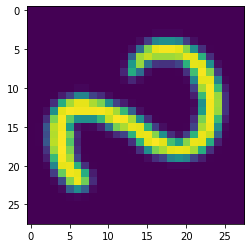

predicted= I


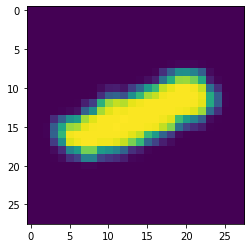

predicted= b


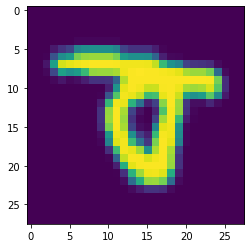

predicted= a


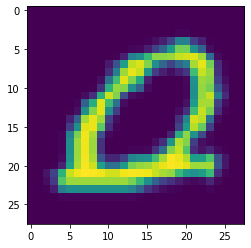

predicted= 8


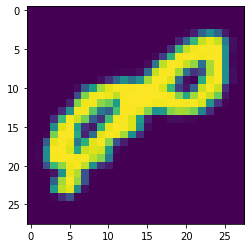

predicted= Q


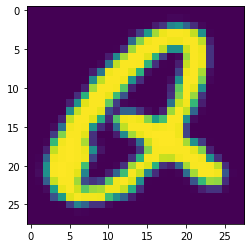

predicted= q


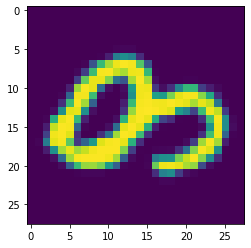

predicted= I


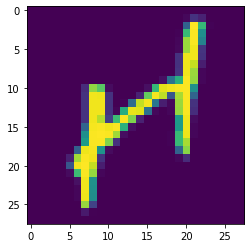

predicted= J


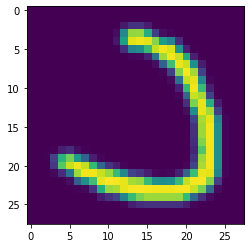

predicted= 8


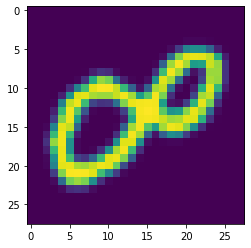

predicted= R


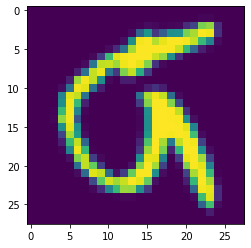

predicted= 8


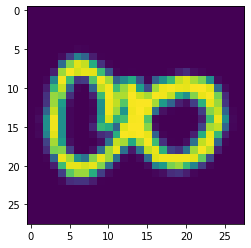

predicted= C


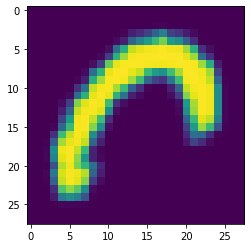

predicted= B


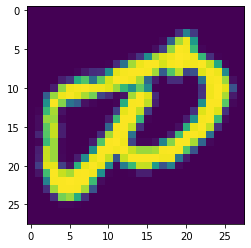

predicted= W


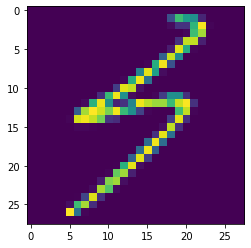

predicted= h


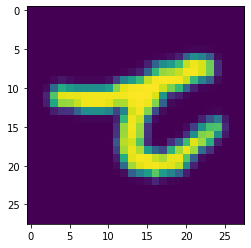

predicted= T


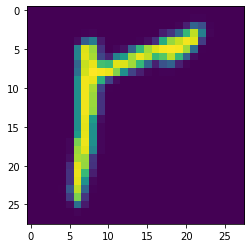

predicted= V


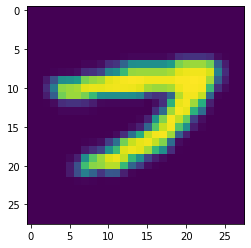

predicted= L


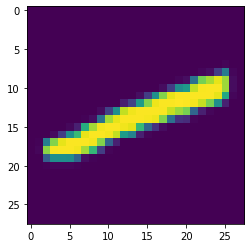

predicted= 4


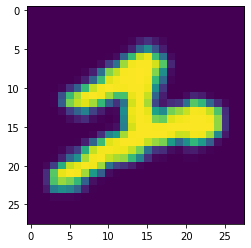

In [182]:
for im in rn.sample(range(0, 2800), 20):
    #print(im)
    i=Custom_model.predict(x_test_minmax[im:im+1])
    print("predicted=", chr(int(map[np.argmax(i),1])))
    plt.imshow(x_test_minmax[im:im+1].reshape(28,28))
    plt.show()